In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from PIL import Image
from skimage import io

In [3]:
import PIL,os,mimetypes, glob
from skimage.io import imread
from natsort import natsorted

In [4]:
Path.ls = lambda x: list(x.iterdir())
PIL.Image.MAX_IMAGE_PIXELS = None

In [5]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [6]:
class ImagePatcher():

    def __init__(self, source, slice_s, patch_overlap):
        self.source = source
        self.slice_s = slice_s
        self.patch_overlap = patch_overlap

    def _get_files(p, fs, extensions=image_extensions):
        p = Path(p)
        res = [p/f for f in fs if not f.startswith('.')
               and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
        return res

    def _read_images(self):
        Images = []
        image_names = sorted(os.listdir(self.source))
        for im in image_names:
            image = plt.imread(os.path.join(dir_path,im))
            Images.append(image)
        return Images



    def _convolution(self, Image, strides, slice_s):
        start_x = 0
        start_y = 0
        n_rows = Image.shape[0]//strides[0] + 1
        minus = divmod(slice_s,strides[0])[0]
        n_columns = Image.shape[1]//strides[1] + 1

        small_images = []
        for i in range(n_rows-1):
            for j in range(n_columns-minus):
                new_start_x = start_x+i*strides[0]
                new_start_y= start_y+j*strides[1]
                small_images.append(Image[new_start_x:new_start_x+self.slice_s,new_start_y:new_start_y+self.slice_s,:])
        return small_images

    def _transform(self, cb):
        image = imread(self.source)
        Images = [image]

        im_size = Images[0].shape
        num_images = len(Images)
        transformed_images = dict()
        Images = np.array(Images, dtype=np.uint8)

        stride_x = []
        stride_y = []

        if self.patch_overlap == None:
            stride_x = self.slice_s
            stride_y = self.slice_s
        elif self.patch_overlap == 0 or self.patch_overlap == 1:
            stride_x = self.slice_s
            stride_y = self.slice_s
        elif self.patch_overlap > 1:
            stride_x = self.slice_s/self.patch_overlap*(self.patch_overlap-1)
            stride_x = int(stride_x)
            stride_y = self.slice_s/self.patch_overlap*(self.patch_overlap-1)
            stride_y = int(stride_x)

        strides = [stride_x, stride_y]

        n_rows = Images[0].shape[0]//strides[0] + 1
        n_columns = Images[0].shape[1]//strides[1] + 1
        if cb: cb.before_cal_2(rows_n= n_rows,columns_n = n_columns )


        for i, Image in enumerate(Images):
            transformed_images[str(i)] = self._convolution(Image, strides, self.slice_s)

        return transformed_images

    def quantile_from_zoom_range(zoom_range):
        if len(list(zoom_range)) == 2:
            _slice_size_0 = int(zoom_range[0])
            _slice_size_1 = int(np.percentile(zoom_range, 25, axis=0))
            _slice_size_2 = int(np.percentile(zoom_range, 50, axis=0))
            _slice_size_3 = int(np.percentile(zoom_range, 75, axis=0))
            _slice_size_4 = int(zoom_range[1])

            zoom_l = [_slice_size_0,_slice_size_1 , _slice_size_2 ,  _slice_size_3 , _slice_size_4 ]
            return zoom_l
        else:
                    return zoom_range


    def show_slices(zoom, inp_d , pos= None):
        
        if isinstance(zoom, int):
            zoom = [zoom]

        if pos == None:
            pos = 0

        inp_d = Path(inp_d)

        sl = [o.name for o in os.scandir(inp_d)]
        sl = ImagePatcher._get_files(inp_d, sl)

        im = Image.open(sl[pos])

        cropped_l = []
        for i in zoom:
            left, top, right, bottom = 0, 0, i, i
            c  = im.crop( ( left, top, right, bottom ) )
            cropped_l.append(c)

        Tot = number_of_subplots=len(zoom)
        Tot = Tot +1
        Cols = 2
        Rows = Tot // Cols
        Rows += Tot % Cols
        Position = range(1,Tot)

        fig = plt.figure(figsize=(12,12))

        for j, k in enumerate(cropped_l):
            ax = fig.add_subplot(Rows,Cols,Position[j])
            ax.imshow(k,interpolation='lanczos' )
            ax.set_axis_off()
            ax.set_title(f'{zoom[j]} Pixel')
        plt.show()

    def slice_images(inp_d = None, dir_name = None, zoom_l = None, patch_size= None, patch_overlap = None, out_path= None, cb=None, half_empty = True):

        inp_d = Path(inp_d)
        if out_path==None:
                    out_path = inp_d
        out_path = Path(inp_d)

        im_l = [o.name for o in os.scandir(inp_d)]
        im_l = ImagePatcher._get_files(inp_d, im_l)

        cb = PrintStatusCallback(patch_overlap,patch_size)

        for i in zoom_l:
            last_slice = zoom_l[-1]

            if cb: cb.before_calc(i)
            for p, im in enumerate(im_l):
                li = len(im_l)
                if cb: cb.status_calc(p , li)
                slicer = ImagePatcher(im, slice_s = i ,patch_overlap=patch_overlap)
                transformed_image = slicer._transform(cb)
                ImagePatcher._save_images(transformed=transformed_image,patch_size=patch_size , out_path=out_path , dir_name=dir_name, _slice_size=i , patch_overlap = patch_overlap, im = im, half_empty = half_empty)
            if cb: cb.after_calc(i, last_slice, out_path/dir_name)

    def _save_images(transformed, out_path, dir_name, patch_size, _slice_size=int , patch_overlap =int ,im = None, half_empty = None):

        if type(patch_size) == tuple:
            resize_t = patch_size
        else:
            resize_t = ()
            resize_t = (patch_size , patch_size)

        (out_path/dir_name).mkdir(exist_ok=True)
        for key, val in transformed.items():
            if not val:
                print("Please decrease zoom level!")
            else: 
                shape = val[0].shape 
                count = shape[0] * shape[0]
                count_h = count//2
                for k, j in enumerate(val):
                    if half_empty == True:
                        m = np.all(j == np.array((0,0,0)).reshape(1, 1, 3), axis=2)
                        non_zero = np.count_nonzero(m)
                        if non_zero <= count_h:
                            img = Image.fromarray(j, 'RGB')
                            diff = _slice_size - resize_t[0]
                            diff_h = diff//2 + resize_t[0]
                            img.resize((diff_h, diff_h),resample=Image.BICUBIC).resize(resize_t, resample= PIL.Image.NEAREST).save(out_path/dir_name/f'{im.stem}_{k}_{patch_overlap}_{_slice_size}.png')
                    else:
                        img = Image.fromarray(j, 'RGB')
                        diff = _slice_size - resize_t[0]
                        diff_h = diff//2 + resize_t[0]
                        img.resize((diff_h, diff_h),resample=Image.BICUBIC).resize(resize_t, resample= PIL.Image.NEAREST).save(out_path/dir_name/f'{im.stem}_{k}_{patch_overlap}_{_slice_size}.png')


    def slice_masks(inp_d = None, dir_name = None ,zoom_l = None,patch_size = None, patch_overlap = None, out_path=None, cb=None, palette = None):

        inp_d = Path(inp_d)
        if out_path==None:
                    out_path = inp_d
        out_path = Path(inp_d)

        mask_l = [o.name for o in os.scandir(inp_d)]
        mask_l = ImagePatcher._get_files(inp_d, mask_l)

        cb = PrintStatusCallback(patch_overlap,resize)

        for i in zoom_l:
            last_slice = zoom_l[-1]

            if cb: cb.before_calc(i)
            for p, im in enumerate(mask_l):
                li = len(mask_l)
                if cb: cb.status_calc(p , li)
                slicer = ImagePatcher(im, slice_s = i ,patch_overlap=patch_overlap)
                transformed_image = slicer._transform(cb)
                ImagePatcher._save_masks(transformed=transformed_image,resize=patch_size , out_path=out_path , dir_name=dir_name, _slice_size=i , patch_overlap = patch_overlap, im = im)
            if cb: cb.after_calc(i, last_slice, out_path/dir_name )

        if palette != None:
                    print("----")
                    print("Convert colour to grey")

                    mask_grey_l = [o.name for o in os.scandir(inp_d/dir_name)]
                    mask_grey_l = ImageSlicer._get_files(inp_d/dir_name, mask_grey_l)
                    PIL.Image.MAX_IMAGE_PIXELS = 933120000
                    for mask in mask_grey_l:
                        mask_r = io.imread(mask)
                        mask_c = ImageSlicer._color_to_grey(mask_rgb = mask_r , palette = palette, out_path =out_path/dir_name/dir_name,dir_name = dir_name , path=mask)

                    print(cb.after_calc(i,last_slice ,out_path/dir_name/dir_name ))


    def add_padding(inp_d, pad = 500):
                    inp_d = Path(inp_d)
                    sl = [o.name for o in os.scandir(inp_d)]
                    sl = ImagePatcher._get_files(inp_d, sl)
                    (inp_d/f'out_padded').mkdir(exist_ok=True)

                    for image in sl:
                        with open(image, 'rb') as file:
                            img = Image.open(file)
                            width, height = img.size
                            new_width = width + pad
                            new_height = height + pad
                            result = Image.new(img.mode, (new_width, new_height))
                            result.paste(img, (0, 0))
                            result.save(inp_d/f'out_padded/{image.stem}.png' )

    def _save_masks(transformed, out_path, dir_name, patch_size, _slice_size=None , patch_overlap =int,im = None):
        if type(patch_size) == tuple:
            resize_t = patch_size
        else:
            resize_t = ()
            resize_t = (patch_size , patch_size)

        (out_path/dir_name).mkdir(exist_ok=True)
        for key, val in transformed.items():
            shape = val[0].shape
            count = shape[0] * shape[0]
            count_h = count//2
            for k, j in enumerate(val):

                m = np.all(j == np.array((0,0,0)).reshape(1, 1, 3), axis=2)
                non_zero = np.count_nonzero(m)
                if non_zero <= count_h:
                    img = Image.fromarray(j, 'RGB')
                    img.resize(resize_t,resample=Image.NEAREST).save(out_path/dir_name/f'{im.stem}_{k}_{patch_overlap}_{_slice_size}.png')

    def _color_to_grey(mask_rgb, palette=None, out_path=None, dir_name=None , path=None):
        """ RGB-color encoding to grayscale labels """
        if palette == None:
            raise Exception("Please insert palette")
        else:
            (out_path).mkdir(exist_ok=True)
            invert_palette = {v: k for k, v in palette.items()}
            mask_g = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)
            for c, i in invert_palette.items():
                m = np.all(mask_rgb == np.array(c).reshape(1, 1, 3), axis=2)
                mask_g[m] = i

            mask_a = Image.fromarray(mask_g, 'L')
            mask_a.save(out_path/f'{path.stem}.png')


    def _convert_to_color(arr_2d, palette=None):
        """ Numeric labels to RGB-color encoding """
        arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

        for c, i in palette.items():
            m = arr_2d == c
            arr_3d[m] = i

        return arr_3d

    def predict_from_fastai_model(path_fastai_model,inp_d, dir_name, palette, rows, columns):
        path_slices = str(inp_d)

        out_f = inp_d/'predicted'
        (out_f).mkdir(exist_ok=True)
        out_folder = inp_d/'predicted'/dir_name
        (out_folder).mkdir(exist_ok=True)

        learn = load_learner(path_model)
        img = []
        for filename in glob.iglob(path_slices + '/*png'):
            if os.path.isfile(filename):
                img.append(filename)
        img_s = natsorted(img)

        ims = [open_image(i) for i in img_s]
        for i in range(len(ims)):
            img_ds = ims[i]
            mask2 = learn.predict(img_ds)[0]
            data_n = mask2.data[0].numpy()
            a = ImageSlicer._convert_to_color(data_n, palette = palette)
            img = Image.fromarray(a, 'RGB')
            img.save(f'{out_folder}/{i}.png')

        img_p = []
        for filename in glob.iglob(str(out_folder)+'/*png'):
            if os.path.isfile(filename): # filter dirs
                img_p.append(filename)
        img_ps = natsorted(img_p)
        test_im = Image.open(img_ps[0])
        size = test_im.size[0]
        out_pred = Path(out_folder/dir_name)
        (out_pred).mkdir(exist_ok=True)

        ImageSlicer._create_collage(img_ps,size=size, rows=rows , columns = columns, out = out_pred )

    def _create_collage(files, size , rows , columns, out):
        target_img = Image.new("RGB", (columns * size-size  ,rows * size-size))
        for k, png in enumerate(files):
            row, col = divmod(k, columns-1)
            img = Image.open(png)
            target_img.paste(img, (size * col, size * row))

        target_img.save(str(out) + '/' + dir_name+ '.png')


class PrintStatusCallback():
    def __init__(self, patch_overlap, path_size, rows=None, columns=None):
                    self.rows = rows
                    self.columns = columns
                    print(f"Patch Size: = {path_size}*{path_size}")
                    print(f"Patch patch_overlap: = {patch_overlap}")
                    print("----")
    def before_calc(self, slice_s ):
                    print(f"Process slice: {slice_s}")

    def before_cal_2(self, rows_n, columns_n):
                    if rows_n != self.rows:
                        self.rows = rows_n
                        print(f"Rows: {self.rows}")
                        print(f"Columns: {columns_n}")
                        print("----")

    def status_calc(self, p ,li): print(f'[{p+1}|{li}]',end='\r')
    def after_calc (self, slice_s, last_slice,out_path, **kwargs):
        if last_slice != None:
            print(f"Finished")
        print("----")
        if slice_s == last_slice:
            print(f'Saved under: {out_path}')
            print('Number of Patches: ' , len(list(out_path.glob('*.png'))))

In [7]:
patch_size = 500 

In [8]:
zoom = 200

In [9]:
pad = 100

In [10]:
inp_d = Path("./Bilder/RGB")

In [11]:
inp_d.exists()

True

In [12]:
ImagePatcher.add_padding(inp_d, pad)

In [13]:
inp_d_2 = Path("./Bilder/RGB/out_padded/") 

In [14]:
zoom_range = [700, 2000]

In [15]:
zoom = ImagePatcher.quantile_from_zoom_range(zoom_range) 

In [16]:
zoom_l = 1000

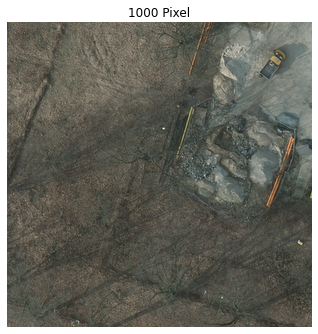

In [17]:
ImagePatcher.show_slices(zoom_l, inp_d_2)

In [81]:
patch_overlap = 2 

In [85]:
dir_name = f'test_{patch_size}_{patch_overlap}_{zoom_l}';dir_name 

'test_500_2_1000'

In [83]:
dir_name = f'test_{patch_size}_{patch_overlap}_{zoom_range[0]}-{zoom_range[1]}';dir_name 

'test_500_2_700-2000'

In [86]:
ImagePatcher.slice_images(inp_d_2, dir_name , zoom, patch_size, patch_overlap)

Patch Size: = 500*500
Patch patch_overlap: = 2
----
Process slice: 700
Rows: 18
Columns: 18
----
Finished
----
Process slice: 1025
Rows: 12
Columns: 12
----
Finished
----
Process slice: 1350
Rows: 10
Columns: 10
----
Finished
----
Process slice: 1675
Rows: 8
Columns: 8
----
Finished
----
Process slice: 2000
Rows: 7
Columns: 7
----
Finished
----
Saved under: Bilder/RGB/out_padded/test_500_2_1000
Number of Patches:  1052
